# Anomaly Detection

En este ejemplo se usa la famosa base de datos [MNIST](https://en.wikipedia.org/wiki/MNIST_database) que tiene en letra manuscrita los 10 dígitos (0,1,...9). Se entrena el modelo para que el '0' sea la clase "normal", y todo el resto de dígitos sea considerado como "anomalía".

Implementacion basada en [f-AnoGan](http://github.com/dbbbbm/f-AnoGAN-PyTorch)

Esta umplementación ocupa como entrada imágenes de 3 canales de color de 64x64 pixeles. En caso de querer usar otras imágenes cambiar la función one_class_dataloader en F-AnoGan. En caso de querer usar otra dimensión de imágenes debería funcionar cambiando DIM y OUTpUT_DIM en WGAN 64x64.

Adaptación hecha por Joaquín Hofmann y Domingo Mery

Referencia:
Schlegl, T., Seeböck, P., Waldstein, S. M., Langs, G., & Schmidt-Erfurth, U. (2019). [f-AnoGAN: Fast unsupervised anomaly detection with generative adversarial networks](https://www.sciencedirect.com/science/article/abs/pii/S1361841518302640). Medical image analysis, 54, 30-44.

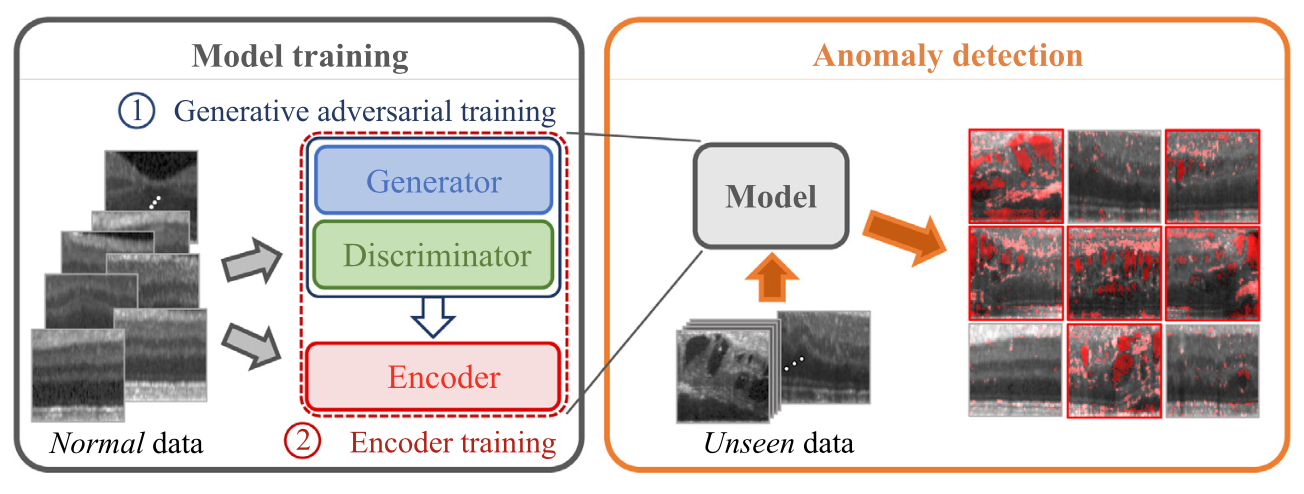

In [1]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"]= "max_split_size_mb:21"
key = "PYTORCH_CUDA_ALLOC_CONF"
value = os.getenv(key)

print(value)

max_split_size_mb:21


# Some functions

In [2]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

# WGAN 64x64

In [3]:
# wgan64x64.py
from torch import nn
from torch.autograd import grad
import torch
DIM = 160
OUTPUT_DIM = 3*160*160

class MyConvo2d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True,  stride=1, bias=True):
        super(MyConvo2d, self).__init__()
        self.he_init = he_init
        self.padding = int((kernel_size - 1)/2)
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size,
                              stride=1, padding=self.padding, bias=bias)

    def forward(self, input):
        output = self.conv(input)
        return output


class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(ConvMeanPool, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = self.conv(input)
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        return output


class MeanPoolConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(MeanPoolConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = input
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        output = self.conv(output)
        return output


class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, input_height, input_width, input_depth) = output.size()
        output_depth = int(input_depth / self.block_size_sq)
        output_width = int(input_width * self.block_size)
        output_height = int(input_height * self.block_size)
        t_1 = output.reshape(batch_size, input_height,
                             input_width, self.block_size_sq, output_depth)
        spl = t_1.split(self.block_size, 3)
        stacks = [t_t.reshape(batch_size, input_height,
                              output_width, output_depth) for t_t in spl]
        output = torch.stack(stacks, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(
            batch_size, output_height, output_width, output_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class UpSampleConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True, bias=True):
        super(UpSampleConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init, bias=bias)
        self.depth_to_space = DepthToSpace(2)

    def forward(self, input):
        output = input
        output = torch.cat((output, output, output, output), 1)
        output = self.depth_to_space(output)
        output = self.conv(output)
        return output


class ResidualBlock(nn.Module):
    # ResidualBlock(dim, dim*2, 3, 'down', 64)
    def __init__(self, input_dim, output_dim, kernel_size, resample=None, hw=DIM):
        super(ResidualBlock, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.resample = resample
        self.bn1 = None
        self.bn2 = None
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        if resample == 'down':
            self.bn1 = nn.LayerNorm([input_dim, hw, hw])
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        elif resample == 'up':
            self.bn1 = nn.BatchNorm2d(input_dim)
            self.bn2 = nn.BatchNorm2d(output_dim)
        elif resample == None:
            # TODO: ????
            self.bn1 = nn.BatchNorm2d(output_dim)
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        else:
            raise Exception('invalid resample value')

        if resample == 'down':
            self.conv_shortcut = MeanPoolConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = ConvMeanPool(
                input_dim, output_dim, kernel_size=kernel_size)
        elif resample == 'up':
            self.conv_shortcut = UpSampleConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = UpSampleConv(
                input_dim, output_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                output_dim, output_dim, kernel_size=kernel_size)
        elif resample == None:
            self.conv_shortcut = MyConvo2d(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                input_dim, output_dim, kernel_size=kernel_size)
        else:
            raise Exception('invalid resample value')

    def forward(self, input):
        if self.input_dim == self.output_dim and self.resample == None:
            shortcut = input
        else:
            shortcut = self.conv_shortcut(input)

        output = input
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv_1(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.conv_2(output)

        return shortcut + output


class ReLULayer(nn.Module):
    def __init__(self, n_in, n_out):
        super(ReLULayer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.linear = nn.Linear(n_in, n_out)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.linear(input)
        output = self.relu(output)
        return output


class FCGenerator(nn.Module):
    def __init__(self, FC_DIM=512):
        super(FCGenerator, self).__init__()
        self.relulayer1 = ReLULayer(128, FC_DIM)
        self.relulayer2 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer3 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer4 = ReLULayer(FC_DIM, FC_DIM)
        self.linear = nn.Linear(FC_DIM, OUTPUT_DIM)
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.relulayer1(input)
        output = self.relulayer2(output)
        output = self.relulayer3(output)
        output = self.relulayer4(output)
        output = self.linear(output)
        output = self.tanh(output)
        return output


class GoodGenerator(nn.Module):
    def __init__(self, dim=DIM, output_dim=OUTPUT_DIM):
        super(GoodGenerator, self).__init__()

        self.dim = dim

        # self.ln1 = nn.Linear(128, 4*4*8*self.dim)
        self.ln1 = nn.Linear(128, 10*10*8*self.dim)
        self.rb1 = ResidualBlock(8*self.dim, 8*self.dim, 3, resample='up')
        self.rb2 = ResidualBlock(8*self.dim, 4*self.dim, 3, resample='up')
        self.rb3 = ResidualBlock(4*self.dim, 2*self.dim, 3, resample='up')
        self.rb4 = ResidualBlock(2*self.dim, 1*self.dim, 3, resample='up')
        self.bn = nn.BatchNorm2d(self.dim)

        self.conv1 = MyConvo2d(1*self.dim, 3, 3)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # print("PEROFORMING __init__")
        self.initialize()

    def initialize(self):
        # print("PEROFORMING INITIALIZATION")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # print("PEROFORMING FORWARD FUNCTION")
        # print("input shape is: ", input.shape)
        output = self.ln1(input.contiguous())
        # print("self.ln1 shape is: ", output.shape)
        # output = output.view(-1, 8*self.dim, 4, 4)
        output = output.view(-1, 8*self.dim, 10, 10)
        # print("output.view shape is: ", output.shape)
        output = self.rb1(output)
        # print("self.rb1 shape is: ", output.shape)
        output = self.rb2(output)
        # print("self.rb2 shape is: ", output.shape)
        output = self.rb3(output)
        # print("self.rb3 shape is: ", output.shape)
        output = self.rb4(output)
        # print("self.rb4 shape is: ", output.shape)

        output = self.bn(output)
        # print("self.bn shape is: ", output.shape)
        output = self.relu(output)
        # print("self.relu shape is: ", output.shape)
        output = self.conv1(output)
        # print("self.conv1 shape is: ", output.shape)
        output = self.tanh(output)
        # print("self.tanh shape is: ", output.shape)
        # print("END OF FORWARD FUNCTION")
        # # output = output.view(-1, OUTPUT_DIM)
        return output




class GoodDiscriminator(nn.Module):
    def __init__(self, dim=DIM):
        super(GoodDiscriminator, self).__init__()

        self.dim = dim

        self.conv1 = MyConvo2d(3, self.dim, 3, he_init=False)
        self.rb1 = ResidualBlock(self.dim, 2*self.dim,
                                 3, resample='down', hw=DIM)
        self.rb2 = ResidualBlock(
            2*self.dim, 4*self.dim, 3, resample='down', hw=int(DIM/2))
        self.rb3 = ResidualBlock(
            4*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/4))
        self.rb4 = ResidualBlock(
            8*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/8))
        # self.ln1 = nn.Linear(4*4*8*self.dim, 1)
        self.ln1 = nn.Linear(10*10*8*self.dim, 1)
        # print("PEROFORMING __init__")
        self.initialize()

    def initialize(self):
        # print("PEROFORMING INITIALIZATION")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def extract_feature(self, input):
        # print("PEROFORMING EXTRACTING FEATURES FUNCTION")
        # print("input shape is: ", input.shape)
        output = input.contiguous()
        # print("input.contigous() shape is: ", output.shape)
        output = output.view(-1, 3, DIM, DIM)
        # print("new shape of output is: ", output.shape)
        output = self.conv1(output)
        # print("after self.conv1, the shape of output is: ", output.shape)
        output = self.rb1(output)
        # print("after self.rb1, the shape of output is: ", output.shape)
        output = self.rb2(output)
        # print("after self.rb2, the shape of output is: ", output.shape)
        output = self.rb3(output)
        # print("after self.rb3, the shape of output is: ", output.shape)
        output = self.rb4(output)
        # print("after self.rb4, the shape of output is: ", output.shape)
        # output = output.view(-1, 4*4*8*self.dim)
        output = output.view(-1, 10*10*8*self.dim)
        # print("after output.view, the shape of output is: ", output.shape)
        # print("END OF THE EXTRACTING FEATURES FUNCTION")  
        return output

    def forward(self, input):
        output = self.extract_feature(input)
        output = self.ln1(output)
        output = output.view(-1)
        # print("PEROFORMING FORWARD")
        return output





class Encoder(nn.Module):
    def __init__(self, dim, output_dim, drop_rate=0.0):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(drop_rate)
        self.conv_in = nn.Conv2d(3, dim, 3, 1, padding=1)
        # self.res1 = ResidualBlock(dim, dim*2, 3, 'down', 64)
        # self.res2 = ResidualBlock(dim*2, dim*4, 3, 'down', 32)
        # self.res3 = ResidualBlock(dim*4, dim*8, 3, 'down', 16)
        # self.res4 = ResidualBlock(dim*8, dim*8, 3, 'down', 8)
        self.res1 = ResidualBlock(dim, dim*2, 3, 'down', 160)
        self.res2 = ResidualBlock(dim*2, dim*4, 3, 'down', 80)
        self.res3 = ResidualBlock(dim*4, dim*8, 3, 'down', 40)
        self.res4 = ResidualBlock(dim*8, dim*8, 3, 'down', 20)
        # self.fc = nn.Linear(4*4*8*dim, output_dim)
        self.fc = nn.Linear(10*10*8*dim, output_dim)


    def forward(self, x):
        # print("PEROFORMING FORWARD FUNCTION")
        # print("x shape is: ", x.shape)
        x = self.dropout(x)
        # print("self.dropout shape is: ", x.shape)
        x = self.conv_in(x)
        # print("self.conv_in shape is: ", x.shape)
        x = self.res1(x)
        # print("self.res1 shape is: ", x.shape)
        x = self.res2(x)
        # print("self.res2 shape is: ", x.shape)
        x = self.res3(x)
        # print("self.res3 shape is: ", x.shape)
        x = self.res4(x)
        # print("self.res4 shape is: ", x.shape)
        x = x.view(x.size(0), -1)
        # print("self.view shape is: ", x.shape)
        x = self.fc(x)
        # print("self.fc shape is: ", x.shape)
        # print("torch.tanh(x) shape is: ", torch.tanh(x).shape)
        return torch.tanh(x)

# F-AnoGan

In [4]:
from torch.utils.data import DataLoader
from torch import optim
from torch import autograd
from torch import nn
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import sampler
from argparse import ArgumentParser
#from wgan64x64 import *
from sklearn import metrics
import torch
from tqdm.auto import tqdm
import numpy as np
import time
import os
import sys
import random
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
sys.path.append(os.getcwd())

MODE = 'wgan-gp'  # Valid options are dcgan, wgan, or wgan-gp

LAMBDA = 10  # Gradient penalty lambda hyperparameter
CRITIC_ITERS = 5  # How many critic iterations per generator iteration
BATCH_SIZE = 5  # Batch size

NOISE_SIZE = 128
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False

def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(BATCH_SIZE, int(real_data.nelement()/BATCH_SIZE)).contiguous()
    alpha = alpha.view(BATCH_SIZE, 3, DIM, DIM)
    alpha = alpha.to(device)

    fake_data = fake_data.view(BATCH_SIZE, 3, DIM, DIM)
    interpolates = alpha * real_data.cuda().detach() + ((1 - alpha) * fake_data.detach())           # For home laptop. GPU capabilites
    # interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())                # For work laptop. No GPU
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(
                                  disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

def one_class_dataloader(c, nw=0, bs=64):

    nw = 0

    data_dir = '../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
    test_dir = '../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop

    transform = transforms.Compose([
            # transforms.RandomCrop(32, padding=4),
            # transforms.RandomHorizontalFlip(),
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5),
            #                      (0.5, 0.5, 0.5)),
        ])

    dataset = datasets.ImageFolder(data_dir, transform = transform)
    trainloader = DataLoader(
        dataset, bs, num_workers=nw, pin_memory=True, drop_last=True) 
    
    dataset_test = datasets.ImageFolder(test_dir, transform = transform)
    dataloader_test = DataLoader(
        dataset_test, bs, num_workers=nw, pin_memory=True, drop_last=False) 


    return trainloader, dataloader_test


def wgan_training(PreTrained=False,saveat=1000,genstart=0):
    netG = GoodGenerator().to(device)
    netD = GoodDiscriminator().to(device)
    if PreTrained: 
      print('loading pretrained discriminator-weights '+D_Model+'...')
      netD.load_state_dict(torch.load(D_Model))
      print('loading pretrained generator-weights '+G_Model+'...')
      netG.load_state_dict(torch.load(G_Model))

    #one = torch.FloatTensor([1]).to(device)
    one = torch.tensor(1, dtype=torch.float).to(device)
    mone = one * -1

    optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.0, 0.9))
    optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.0, 0.9))

    dataloader, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)
    D_real_list = []
    D_fake_list = []
    D_cost_list = []
    G_cost_list = []
    for iteration in tqdm(range(1+genstart, WGAN_ITERS + 1)):
        #print('WGAN - Iteration:'+str(iteration))
        start_time = time.time()
        ############################
        # (1) Update D network
        ###########################
        for i, (_data, _) in enumerate(dataloader):
            if i == CRITIC_ITERS:
                break
            netD.zero_grad()

            # train with real

            real_data = _data.to(device)
            imgs_croped = transforms.functional.crop(real_data.cuda(), 60, 30, 160, 160)

            D_real = netD(imgs_croped.cuda())
            D_real = D_real.mean()
            D_real.backward(mone)
            D_real_list.append(D_real.item())

            # train with fake
            noise = torch.randn(BATCH_SIZE, NOISE_SIZE)
            noise = noise.to(device)
            fake = netG(noise).detach()
            inputv = fake
            D_fake = netD(inputv)
            D_fake = D_fake.mean()
            D_fake.backward(one)
            D_fake_list.append(D_fake.item())

            # train with gradient penalty
            gradient_penalty = calc_gradient_penalty(netD, imgs_croped.cuda().data, fake.data)
            gradient_penalty.backward()

            # print "gradien_penalty: ", gradient_penalty

            D_cost = D_fake - D_real + gradient_penalty
            D_cost_list.append(D_cost.item())
            Wasserstein_D = D_real - D_fake
            optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()

        noise = torch.randn(BATCH_SIZE, 128)
        noise = noise.to(device)
        fake = netG(noise)
        G = netD(fake)
        G = G.mean()
        G.backward(mone)
        G_cost = -G
        optimizerG.step()
        G_cost_list.append(G_cost.item())

        # Write logs and save samples

        if iteration % saveat == 0:
            save_image(fake*0.5+0.5, 'BS_10/wgangp/fake_' + num2fixstr(iteration,5) + '.jpg')
            print('Iters:{}, D(real):{}, D(fake):{}, Loss D:{}, Loss G:{}'.format(
                iteration,
                np.mean(D_real_list),
                np.mean(D_fake_list),
                np.mean(D_cost_list),
                np.mean(G_cost_list),)
            )
        if iteration % saveat == 0 and iteration != 0:
            torch.save(netD.state_dict(), 'BS_10/models/netD_' + num2fixstr(iteration,5) + '.pth')
            torch.save(netG.state_dict(), 'BS_10/models/netG_' + num2fixstr(iteration,5) + '.pth')
    
def train_encoder(PreTrained=False,saveat=100,genstart=0):
    netG = GoodGenerator().to(device)
    netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
    # netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netG.eval()
    netD = GoodDiscriminator().to(device)
    netD.load_state_dict(torch.load(D_Model))
    # netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netD.eval()
    for p in netD.parameters():
        p.requires_grad = False
    for p in netG.parameters():
        p.requires_grad = False

    dataloader, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)

    netE = Encoder(DIM, NOISE_SIZE).to(device)
    if PreTrained:
      netE.load_state_dict(torch.load(E_Model))

    optimizer = optim.Adam(netE.parameters(), 1e-4, (0.0, 0.9))

    crit = nn.MSELoss()
    # torch.cuda.empty_cache()

    for iteration in tqdm(range(1+genstart, ENCODER_ITERS+1)):
        losses = []
        netE.train()
        print("iteration is: ", iteration)
        i=0
        for (x, _) in dataloader:
            x = x.to(device)
            imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
            code = netE(imgs_croped.cuda()) 
            rec_image = netG(code)
            d_input = torch.cat((imgs_croped, rec_image), dim=0)
            f_x, f_gx = netD.extract_feature(d_input).chunk(2, 0)
            loss = crit(rec_image, imgs_croped) + options_alpha * crit(f_gx, f_x.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            print(i)
            i=i+1
        print(iteration, np.mean(losses))
        netE.eval()
        rec_image = netG(netE(imgs_croped))
        d_input = torch.cat((imgs_croped, rec_image), dim=0)
        
        if iteration % saveat == 0:
            save_image(d_input*0.5+0.5, 'ForBottlesTrainings/rec/rec_'+num2fixstr(iteration,4)+'.png')
        if iteration % saveat == 0 and iteration != 0:
            torch.save(netE.state_dict(), 'ForBottlesTrainings/models/netE_' + num2fixstr(iteration,5) + '.pth')
    torch.save(netE.state_dict(), 'ForBottlesTrainings/models/netE.pth')


c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initial Settings

In [5]:
!mkdir wgangp
!mkdir rec
!mkdir models

A subdirectory or file wgangp already exists.
A subdirectory or file rec already exists.
A subdirectory or file models already exists.


In [6]:
options_c     = 0 # <- normal class
options_alpha = 1
options_cuda  = '0'
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
        torch.cuda.set_device('cuda:{}'.format(options_cuda))
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

# device2 = torch.device('cuda:{}'.format(options_cuda))
# torch.cuda.set_device('cuda:{}'.format(options_cuda))

cuda:0


In [7]:
print(torch.cuda.is_available())

True


# Training WGAN

In [8]:
genstart   = 0 # generación de partida (en caso de existir entrenamiento previo)
G_Model    = 'ForBottlesTrainings/models/netG_' + num2fixstr(genstart,5) + '.pth'
D_Model    = 'ForBottlesTrainings/models/netD_' + num2fixstr(genstart,5) + '.pth'

# saveat     = 50   # cada cuantas iteraciones se guarda modelo
# WGAN_ITERS = 100  # iteraciones máximas del entrenamiento
saveat     = 200   # cada cuantas iteraciones se guarda modelo
WGAN_ITERS = 1000  # iteraciones máximas del entrenamiento
pretrained = genstart>0


In [9]:
# wgan_training(PreTrained=pretrained,saveat=saveat,genstart=genstart)

# Training Encoder-Decoder

In [10]:
encstart      = 0
# ENCODER_ITERS = 20
# saveat        = 10 # cada cuantas iteraciones se guarda modelo
ENCODER_ITERS = 500
saveat        = 100 # cada cuantas iteraciones se guarda modelo

gen           = WGAN_ITERS #generación del generator a usar
G_Model       = 'ForBottlesTrainings/models/netG_' + num2fixstr(gen,5) + '.pth'
D_Model       = 'ForBottlesTrainings/models/netD_' + num2fixstr(gen,5) + '.pth'
E_Model       = 'ForBottlesTrainings/models/netE_' + num2fixstr(encstart,5) + '.pth'

pretrained    = encstart>0

In [11]:

# train_encoder(PreTrained=pretrained,saveat=saveat)

# Evaluation

In [12]:
Ggen    = WGAN_ITERS #generación del generator a usar del generator
Egen    = ENCODER_ITERS #generación a usar del Encoder

G_Model = 'ForBottlesTrainings/models/netG_' + num2fixstr(Ggen,5) + '.pth'
D_Model = 'ForBottlesTrainings/models/netD_' + num2fixstr(Ggen,5) + '.pth'
E_Model = 'ForBottlesTrainings/models/netE.pth'




## Testing the "evaluate()" function, step by step

In [13]:
netG = GoodGenerator().to(device)
netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
# netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netG.eval()
netD = GoodDiscriminator().to(device)
netD.load_state_dict(torch.load(D_Model))                                     #For home laptop, using GPU
# netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netD.eval()
netE = Encoder(DIM, NOISE_SIZE).to(device)
netE.load_state_dict(torch.load(E_Model))                                     #For home laptop, using GPU
# netE.load_state_dict(torch.load(E_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netE.eval()

dataloader,_ = one_class_dataloader(options_c, 0, BATCH_SIZE)


Dataloader is the container of all the batches of images. It also corresponds to the train set images. 

In [14]:
print(len(dataloader))

35


In [15]:
images, labels = next(iter(dataloader))
print(len(images))
print(images[0].shape)

5
torch.Size([3, 224, 224])


In [16]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        print("this is x: ", len(label))
        print("This is the first element of the label variable", label[0])
        

  6%|▌         | 2/35 [00:00<00:03,  8.86it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)


 11%|█▏        | 4/35 [00:00<00:03,  8.49it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)


 17%|█▋        | 6/35 [00:00<00:03,  8.67it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)


 23%|██▎       | 8/35 [00:00<00:03,  8.93it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)
this is x: 

 29%|██▊       | 10/35 [00:01<00:02,  9.30it/s]

 5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)


 34%|███▍      | 12/35 [00:01<00:02,  8.70it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)


 40%|████      | 14/35 [00:01<00:02,  8.72it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)


 43%|████▎     | 15/35 [00:01<00:02,  9.01it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)
this is x: 

 51%|█████▏    | 18/35 [00:01<00:01,  9.54it/s]

 5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable 

 57%|█████▋    | 20/35 [00:02<00:01,  9.57it/s]

tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)


 63%|██████▎   | 22/35 [00:02<00:01,  9.24it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)


 69%|██████▊   | 24/35 [00:02<00:01,  8.72it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)


 74%|███████▍  | 26/35 [00:02<00:01,  8.91it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)
this is x: 

 80%|████████  | 28/35 [00:03<00:00,  9.56it/s]

 5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)
this is x: 

 86%|████████▌ | 30/35 [00:03<00:00,  9.76it/s]

 5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)
this is x: 

 91%|█████████▏| 32/35 [00:03<00:00,  9.71it/s]

 5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)


 97%|█████████▋| 34/35 [00:03<00:00,  9.43it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)
this is x: 

100%|██████████| 35/35 [00:03<00:00,  9.19it/s]

 5
This is the first element of the label variable tensor(0)


Above we can see the first label element of all the batches in the training set

In [17]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        x = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
        if i == 0:
            print("this is the shape of the images that will be fed to the enocder model: ", imgs_croped.shape)
            aux = netE(imgs_croped.cuda())
            # print("this is aux: ", aux)
        i = i+1
        
print("this is the shape of the output of the enconder model: ", aux.shape)
# print("This is the shape of the first element of the aux variable", aux[0].shape)

  0%|          | 0/35 [00:00<?, ?it/s]

this is the shape of the images that will be fed to the enocder model:  torch.Size([5, 3, 160, 160])


100%|██████████| 35/35 [00:08<00:00,  4.04it/s]

this is the shape of the output of the enconder model:  torch.Size([5, 128])


In [18]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        x = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
        if i == 0:
            rec_image = netG(netE(imgs_croped)) 
            # print("this is aux: ", aux)
        i = i+1
        
print("this is the shape of the output of the generator model: ", rec_image.shape)

100%|██████████| 35/35 [00:06<00:00,  5.33it/s]

this is the shape of the output of the generator model:  torch.Size([5, 3, 160, 160])


In [19]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        x = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
        if i == 0:
            rec_image = netG(netE(imgs_croped)) 
            d_input       = torch.cat((imgs_croped, rec_image), dim=0)   
            print("this is d_input: ", d_input)
        i = i+1
        
print("this is the shape of d_input, the concatenation of x and rec_image: ", d_input.shape)

  0%|          | 0/35 [00:00<?, ?it/s]

this is d_input:  

  9%|▊         | 3/35 [00:00<00:06,  5.29it/s]

tensor([[[[0.8353, 0.8431, 0.8510,  ..., 0.7255, 0.7137, 0.7137],
          [0.8353, 0.8431, 0.8510,  ..., 0.7333, 0.7255, 0.7098],
          [0.8314, 0.8392, 0.8510,  ..., 0.7255, 0.7137, 0.7137],
          ...,
          [0.3961, 0.3922, 0.3922,  ..., 0.3176, 0.3373, 0.3490],
          [0.3843, 0.3922, 0.3843,  ..., 0.3137, 0.3255, 0.3451],
          [0.3843, 0.3922, 0.3843,  ..., 0.3176, 0.3294, 0.3294]],

         [[0.8353, 0.8431, 0.8510,  ..., 0.7255, 0.7137, 0.7137],
          [0.8353, 0.8431, 0.8510,  ..., 0.7333, 0.7255, 0.7098],
          [0.8314, 0.8392, 0.8510,  ..., 0.7255, 0.7137, 0.7137],
          ...,
          [0.3961, 0.3922, 0.3922,  ..., 0.3176, 0.3373, 0.3490],
          [0.3843, 0.3922, 0.3843,  ..., 0.3137, 0.3255, 0.3451],
          [0.3843, 0.3922, 0.3843,  ..., 0.3176, 0.3294, 0.3294]],

         [[0.8353, 0.8431, 0.8510,  ..., 0.7255, 0.7137, 0.7137],
          [0.8353, 0.8431, 0.8510,  ..., 0.7333, 0.7255, 0.7098],
          [0.8314, 0.8392, 0.8510,  ..., 0

100%|██████████| 35/35 [00:03<00:00, 10.57it/s]

this is the shape of d_input, the concatenation of x and rec_image:  torch.Size([10, 3, 160, 160])


Looking at the content of the image from the training set and its generated image:

In [20]:
images, labels = next(iter(dataloader))
images = images.to(device)                        # Taking the entire batch to the available device
imgs_croped = transforms.functional.crop(images.cuda(), 60, 30, 160, 160)
print("These are the values of the batch of images:", imgs_croped)
print(imgs_croped.shape)

These are the values of the batch of images: tensor([[[[0.8353, 0.8431, 0.8510,  ..., 0.7255, 0.7137, 0.7137],
          [0.8353, 0.8431, 0.8510,  ..., 0.7333, 0.7255, 0.7098],
          [0.8314, 0.8392, 0.8510,  ..., 0.7255, 0.7137, 0.7137],
          ...,
          [0.3961, 0.3922, 0.3922,  ..., 0.3176, 0.3373, 0.3490],
          [0.3843, 0.3922, 0.3843,  ..., 0.3137, 0.3255, 0.3451],
          [0.3843, 0.3922, 0.3843,  ..., 0.3176, 0.3294, 0.3294]],

         [[0.8353, 0.8431, 0.8510,  ..., 0.7255, 0.7137, 0.7137],
          [0.8353, 0.8431, 0.8510,  ..., 0.7333, 0.7255, 0.7098],
          [0.8314, 0.8392, 0.8510,  ..., 0.7255, 0.7137, 0.7137],
          ...,
          [0.3961, 0.3922, 0.3922,  ..., 0.3176, 0.3373, 0.3490],
          [0.3843, 0.3922, 0.3843,  ..., 0.3137, 0.3255, 0.3451],
          [0.3843, 0.3922, 0.3843,  ..., 0.3176, 0.3294, 0.3294]],

         [[0.8353, 0.8431, 0.8510,  ..., 0.7255, 0.7137, 0.7137],
          [0.8353, 0.8431, 0.8510,  ..., 0.7333, 0.7255, 0.7098

In [21]:
rec_image = netG(netE(imgs_croped)) 
print("These are the values of the generated images:", rec_image)
print(rec_image.shape)

These are the values of the generated images: tensor([[[[0.7651, 0.7821, 0.7925,  ..., 0.6742, 0.6580, 0.6342],
          [0.8294, 0.8017, 0.7922,  ..., 0.6775, 0.6854, 0.6762],
          [0.8368, 0.7851, 0.7886,  ..., 0.6704, 0.6798, 0.6977],
          ...,
          [0.3484, 0.3632, 0.3766,  ..., 0.3208, 0.3322, 0.3221],
          [0.3417, 0.3750, 0.3749,  ..., 0.3245, 0.3255, 0.3125],
          [0.3618, 0.3601, 0.3845,  ..., 0.3100, 0.3213, 0.2683]],

         [[0.7479, 0.8052, 0.8067,  ..., 0.7172, 0.7193, 0.6282],
          [0.8282, 0.8193, 0.8258,  ..., 0.6955, 0.6924, 0.7196],
          [0.8296, 0.8044, 0.8110,  ..., 0.6902, 0.7013, 0.7367],
          ...,
          [0.3609, 0.3693, 0.3689,  ..., 0.3010, 0.3024, 0.3219],
          [0.3447, 0.3636, 0.3597,  ..., 0.3099, 0.3135, 0.3360],
          [0.2963, 0.3935, 0.4094,  ..., 0.3064, 0.3166, 0.2883]],

         [[0.7368, 0.8354, 0.8314,  ..., 0.7263, 0.7053, 0.5749],
          [0.8213, 0.8488, 0.8502,  ..., 0.7177, 0.7241, 0.673

Let's show one image of the batch of train images and one image of the generated images.

This is a sample of the original images of the test set


(160, 160, 3)


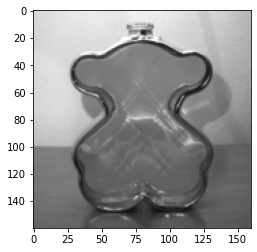

In [22]:
images, labels = next(iter(dataloader))
images = images.to(device)                        # Taking the entire batch to the available device
imgs_croped = transforms.functional.crop(images.cuda(), 60, 30, 160, 160)
single_img = imgs_croped[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()
print(single_img_numpy.shape)
plt.imshow(single_img_numpy)

A sample of the generated images of the train set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(160, 160, 3)


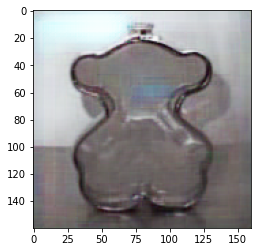

In [23]:
rec_image = netG(netE(imgs_croped)) 
single_img = rec_image[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()
print(single_img_numpy.shape)
plt.imshow(single_img_numpy)

See that the generated image looks not that good. It could be that the model need more iterations for training.
- UPDATE: The models were trained with more iterations

In [24]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        print(label)
        


  6%|▌         | 2/35 [00:00<00:02, 11.60it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])


 17%|█▋        | 6/35 [00:00<00:02, 12.03it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])


 23%|██▎       | 8/35 [00:00<00:02, 10.96it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])


 29%|██▊       | 10/35 [00:00<00:02, 10.64it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])

 34%|███▍      | 12/35 [00:01<00:02,  9.91it/s]


tensor([0, 0, 0, 0, 0])


 40%|████      | 14/35 [00:01<00:02,  9.41it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])


 46%|████▌     | 16/35 [00:01<00:02,  9.44it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])


 51%|█████▏    | 18/35 [00:01<00:01,  9.14it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])


 57%|█████▋    | 20/35 [00:02<00:01,  9.18it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])


 63%|██████▎   | 22/35 [00:02<00:01,  9.30it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])

 69%|██████▊   | 24/35 [00:02<00:01,  9.60it/s]


tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])


 74%|███████▍  | 26/35 [00:02<00:00,  9.94it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])

 86%|████████▌ | 30/35 [00:02<00:00, 10.64it/s]


tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])


 91%|█████████▏| 32/35 [00:03<00:00, 10.42it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])

 97%|█████████▋| 34/35 [00:03<00:00, 10.62it/s]


tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])

100%|██████████| 35/35 [00:03<00:00, 10.09it/s]

In [25]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        if i == 0:
            idx           = (label == options_c)    
            # print("this is aux: ", aux)
        i = i+1
        


100%|██████████| 35/35 [00:03<00:00,  9.30it/s]


In [26]:
print("this is idx : ", idx)
print("this is the len of idx : ", len(idx))

this is idx :  tensor([True, True, True, True, True])
this is the len of idx :  5


Above, from the images of a batch of the train set, we assign "True" where the image is a non-anomaly image.

In [27]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        
        if i == 0:
            x = x.to(device)                        # Taking the entire batch to the available device
            imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
            idx = (label == options_c)  
            aux = imgs_croped[idx]
            # print("this is aux: ", aux)
        i = i+1
        
print("this is idx : ", idx)
print("this is the len of aux : ", len(aux))

100%|██████████| 35/35 [00:03<00:00,  9.03it/s]

this is idx :  tensor([True, True, True, True, True])
this is the len of aux :  5


The variable "aux" is suppossed to contain the images that correspond to the non-anomaly images

In [28]:
print("this is the shape of an element of aux : ", aux[0].shape)

this is the shape of an element of aux :  torch.Size([3, 160, 160])


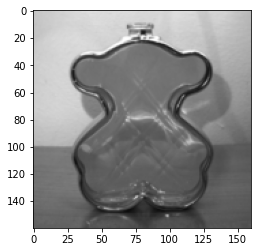

In [29]:
single_img = aux[2]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

In [30]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        
        if i == 0:
            x = x.to(device)                        # Taking the entire batch to the available device
            imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
            idx = (label == options_c)  
            in_real.append(imgs_croped[idx])
            # print("this is aux: ", aux)
        i = i+1
        


100%|██████████| 35/35 [00:03<00:00,  9.78it/s]


In [31]:
print("this is the len of in_real : ", len(in_real))
print("this is the number of images that the only element of 'in_real' contains : ", len(in_real[0]))

this is the len of in_real :  1
this is the number of images that the only element of 'in_real' contains :  5


Now, testing to store the images from ALL the batches, not only one.

In [32]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        x = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
        idx = (label == options_c)  
        in_real.append(imgs_croped[idx])
        # print("this is aux: ", aux)



100%|██████████| 35/35 [00:03<00:00,  9.73it/s]


In [33]:
print("this is the len of in_real : ", len(in_real))

this is the len of in_real :  35


In [34]:
for i in range(len(in_real)):
    print("this is the number of non-anomaly images that the 'in_real' variable contains : ", len(in_real[i]))

this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this

Above we can see the quantity of images of the non-anomaly images that each batch contains. It is as expected, all the batches contains 5 samples of non-anomalies images

In [35]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        if i == 0:           
            x             = x.to(device)                        # Taking the entire batch to the available device
            imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
            rec_image     = netG(netE(imgs_croped))                       # The result of the encoder model is fed to the generator model. The result is a batch of generated images
            d_input       = torch.cat((imgs_croped, rec_image), dim=0)    # Concatenation of the batch of images and their generated image. The result is of shape [120, 3, 64, 64]   
            print("this is the shape of d_input, the concatenation of x and rec_image: ", d_input.shape)  
            f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)   
        i = i+1
        
print("this is f_x : ", f_x)
print("this is the shape of f_x : ", f_x.shape)


print("this is f_gx : ", f_gx)
print("this is the shape of f_gx : ", f_gx.shape)

  0%|          | 0/35 [00:00<?, ?it/s]

this is the shape of d_input, the concatenation of x and rec_image:  torch.Size([10, 3, 160, 160])


100%|██████████| 35/35 [00:08<00:00,  3.94it/s]

this is f_x :  tensor([[-2.2965, -3.0766, -3.2256,  ...,  3.7872,  3.5347,  3.6565],
        [-2.2448, -3.0066, -3.1581,  ...,  3.7729,  3.5326,  3.6491],
        [-2.1881, -2.9816, -3.1560,  ...,  3.7701,  3.5392,  3.6490],
        [-2.2544, -3.0421, -3.2394,  ...,  3.7601,  3.5365,  3.6466],
        [-2.2464, -3.0238, -3.2057,  ...,  3.7545,  3.5385,  3.6436]],
       device='cuda:0')
this is the shape of f_x :  torch.Size([5, 128000])
this is f_gx :  tensor([[-2.4956, -3.2752, -3.4312,  ...,  3.7443,  3.5236,  3.6510],
        [-2.4956, -3.2752, -3.4312,  ...,  3.7443,  3.5236,  3.6510],
        [-2.4956, -3.2752, -3.4312,  ...,  3.7443,  3.5236,  3.6510],
        [-2.4956, -3.2752, -3.4312,  ...,  3.7443,  3.5236,  3.6510],
        [-2.4956, -3.2752, -3.4312,  ...,  3.7443,  3.5236,  3.6510]],
       device='cuda:0')
this is the shape of f_gx :  torch.Size([5, 128000])


In [36]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        if i == 0:    
            bs            = x.size(0)       
            x             = x.to(device)                        # Taking the entire batch to the available device
            imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
            rec_image     = netG(netE(imgs_croped))                       # The result of the encoder model is fed to the generator model. The result is a batch of generated images
            x0            = imgs_croped.reshape(imgs_croped.size(0),-1)
            x1            = rec_image.reshape([bs, OUTPUT_DIM])  
        i = i+1
        
print("the shape of hte images in the test set is: ", imgs_croped.shape)
print("the shape of rec_image is: ", rec_image.shape)
print("the shape of x0 is: ", x0.shape)
print("the shape of x1 is: ", x1.shape)

100%|██████████| 35/35 [00:03<00:00,  9.01it/s]

the shape of hte images in the test set is:  torch.Size([5, 3, 160, 160])
the shape of rec_image is:  torch.Size([5, 3, 160, 160])
the shape of x0 is:  torch.Size([5, 76800])
the shape of x1 is:  torch.Size([5, 76800])


In variables "x0" and "x1" it is stored a reshape of the original and reconstructed images respectively. It is reshaped in order to later subtract one from another. 

This line of code:

x0            = imgs_croped.reshape(imgs_croped.size(0),-1)

it used to be:

x0            = imgs_croped.view(imgs_croped.size(0),-1)

But it was changed due to an error. 

In [37]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        if i == 0:    
            bs            = x.size(0)       
            x             = x.to(device)                        # Taking the entire batch to the available device
            imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
            rec_image     = netG(netE(imgs_croped))                       # The result of the encoder model is fed to the generator model. The result is a batch of generated images
            d_input       = torch.cat((imgs_croped, rec_image), dim=0)    # Concatenation of the batch of images and their generated image. The result is of shape [120, 3, 64, 64] 

            f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)   

            x0            = imgs_croped.reshape(imgs_croped.size(0),-1)
            x1            = rec_image.reshape([bs, OUTPUT_DIM])  

            rec_diff      = (x1 - x0)**2
            rec_score     = rec_diff.mean(dim=1)

            feat_diff     = ((f_x - f_gx)**2)
            feat_score    = feat_diff.mean(dim=1)

            outlier_score = rec_score + options_alpha * feat_score

        i = i+1
        


100%|██████████| 35/35 [00:04<00:00,  8.39it/s]


In [38]:
print("the shape of rec_diff is: ", rec_diff.shape)
print("the shape of rec_score is: ", rec_score.shape)

print("the shape of feat_diff is: ", feat_diff.shape)
print("the shape of feat_score is: ", feat_score.shape)

print("the outlier_score is: ", outlier_score)
print("the shape of outlier_score is: ", outlier_score.shape)

the shape of rec_diff is:  torch.Size([5, 76800])
the shape of rec_score is:  torch.Size([5])
the shape of feat_diff is:  torch.Size([5, 128000])
the shape of feat_score is:  torch.Size([5])
the outlier_score is:  tensor([0.0202, 0.0260, 0.0283, 0.0248, 0.0299], device='cuda:0')
the shape of outlier_score is:  torch.Size([5])


In [39]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" refers to the batch of labels, which take numbers from 0 to 9
        bs            = x.size(0)                           # The element 0 of size of a batch of images is 60.           
        x             = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
        rec_image     = netG(netE(imgs_croped))                       # The result of the encoder model is fed to the generator model. The result is a batch of generated images
        idx           = (label == options_c)                # List of true/false, true where the labels are equal to the normal class 
        in_real.append(imgs_croped[idx])                              # Grab those images from the batch of images, that correspond to a "zero" image
        in_rec.append(rec_image[idx])                       # Grab those images from the generated images, that correspond to a "zero" image
        idx           = (label != options_c)                # List of true/false, true where the labels are different to the normal class 
        out_real.append(imgs_croped[idx])                             # Grab images from the batch of images, that don't correspond to a "zero" image
        out_rec.append(rec_image[idx])                      # Grab images from the generated images, that don't correspond to a "zero" image




100%|██████████| 35/35 [00:13<00:00,  2.56it/s]


In [40]:
print("in_real length is: ", len(in_real))
print("in_rec length is: ", len(in_rec))                
print("out_real length is: ", len(out_real))
print("out_rec length is: ", len(out_rec))


in_real length is:  35
in_rec length is:  35
out_real length is:  35
out_rec length is:  35


Let's see one of the images of the in_rec list. A reconstructed image that is generated from an original non-anomaly image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


this is the shape of an element of in_rec :  torch.Size([5, 3, 160, 160])


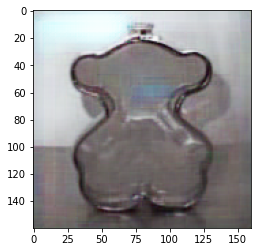

In [41]:
print("this is the shape of an element of in_rec : ", in_rec[0].shape)
single_batch = in_rec[0]
single_img = single_batch[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

Now, one image of the out_real list. This is an original anomaly image

In [42]:
# single_batch = out_real[0]
# single_img = single_batch[0]
# single_img_permuted = single_img.permute(1, 2, 0) 
# single_img_numpy = single_img_permuted.cpu().detach().numpy()

# plt.imshow(single_img_numpy)

Above is as expected. Since in the training set there is not any anomaly image.

And one image of the out_rec list. This is a reconstructed image generated upon an anomaly original image

In [43]:
# single_batch = out_rec[0]
# single_img = single_batch[0]
# single_img_permuted = single_img.permute(1, 2, 0) 
# single_img_numpy = single_img_permuted.cpu().detach().numpy()

# plt.imshow(single_img_numpy)

And this is the same as the previous one. It is empty because there is not any anomaly image.

Before proceeding with the next part, that is concatenating the lists, we show the shape and len of the lists

In [44]:
print("in_real length is: ", len(in_real))
print("in_rec length is: ", len(in_rec))
print("out_real length is: ", len(out_real))
print("out_rec length is: ", len(out_rec))

print("in_real, one of the elemnts of this batch, has shape: ", in_real[0].shape)
print("in_rec, one of the elemnts of this batch, has shape: ", in_rec[0].shape)
print("out_real, one of the elemnts of this batch, has shape: ", out_real[0].shape)
print("out_rec, one of the elemnts of this batch, has shape: ", out_rec[0].shape)

in_real length is:  35
in_rec length is:  35
out_real length is:  35
out_rec length is:  35
in_real, one of the elemnts of this batch, has shape:  torch.Size([5, 3, 160, 160])
in_rec, one of the elemnts of this batch, has shape:  torch.Size([5, 3, 160, 160])
out_real, one of the elemnts of this batch, has shape:  torch.Size([0, 3, 160, 160])
out_rec, one of the elemnts of this batch, has shape:  torch.Size([0, 3, 160, 160])


Proceeding with the next part. Concatenating the lists

In [45]:
in_real = torch.cat(in_real, dim=0)[:32]
in_rec = torch.cat(in_rec, dim=0)[:32]
out_real = torch.cat(out_real, dim=0)[:32]
out_rec = torch.cat(out_rec, dim=0)[:32]

print("in_real length is: ", len(in_real))
print("in_rec length is: ", len(in_rec))
print("out_real length is: ", len(out_real))
print("out_rec length is: ", len(out_rec))

print("in_real, one of the elemnts of this batch, has shape: ", in_real[0].shape)
print("in_rec, one of the elemnts of this batch, has shape: ", in_rec[0].shape)
# print("out_real, one of the elemnts of this batch, has shape: ", out_real[0].shape)
# print("out_rec, one of the elemnts of this batch, has shape: ", out_rec[0].shape)

in_real length is:  32
in_rec length is:  32
out_real length is:  0
out_rec length is:  0
in_real, one of the elemnts of this batch, has shape:  torch.Size([3, 160, 160])
in_rec, one of the elemnts of this batch, has shape:  torch.Size([3, 160, 160])


Above, the concatenation of lists "in_real" and "in_rec" is a concatenation of real non-anomaly and reconstructed of non-anomaly images respectively.
Whereas the concatenation of lists "out_real" and "out_rec" is a concatenation of real anomaly and reconstructed of anomaly images respectively. Since we don't have anomaly samples, this last concatenation list, does not exist.

In [46]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
           
        bs            = x.size(0)       
        x             = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
        rec_image     = netG(netE(imgs_croped))                       # The result of the encoder model is fed to the generator model. The result is a batch of generated images
        d_input       = torch.cat((imgs_croped, rec_image), dim=0)    # Concatenation of the batch of images and their generated image. The result is of shape [120, 3, 64, 64] 

        f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)   

        x0            = imgs_croped.reshape(imgs_croped.size(0),-1)
        x1            = rec_image.reshape([bs, OUTPUT_DIM])  

        rec_diff      = (x1 - x0)**2
        rec_score     = rec_diff.mean(dim=1)

        feat_diff     = ((f_x - f_gx)**2)
        feat_score    = feat_diff.mean(dim=1)

        outlier_score = rec_score + options_alpha * feat_score

        y_true.append(label)
        y_score.append(outlier_score.cpu())
        

100%|██████████| 35/35 [00:26<00:00,  1.34it/s]


In [47]:
print("y_true length is: ", len(y_true))
print("y_score length is: ", len(y_score))

print("y_true, one of the elemnts of this batch, has shape: ", y_true[0].shape)
print("y_score, one of the elemnts of this batch, has shape: ", y_score[0].shape)



y_true length is:  35
y_score length is:  35
y_true, one of the elemnts of this batch, has shape:  torch.Size([5])
y_score, one of the elemnts of this batch, has shape:  torch.Size([5])


In [48]:
print("y_true is: ", y_true)

y_true is:  [tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0])]


In [49]:
print("y_score is: ", y_score)

y_score is:  [tensor([0.0202, 0.0260, 0.0283, 0.0248, 0.0299]), tensor([0.0242, 0.0463, 0.0477, 0.0460, 0.0512]), tensor([0.0524, 0.0419, 0.0289, 0.0274, 0.0259]), tensor([0.0456, 0.0461, 0.0651, 0.0561, 0.0317]), tensor([0.0165, 0.0167, 0.0152, 0.0197, 0.0376]), tensor([0.0251, 0.0155, 0.0164, 0.0177, 0.0184]), tensor([0.0365, 0.0409, 0.0221, 0.0219, 0.0239]), tensor([0.0190, 0.0203, 0.0169, 0.0136, 0.0120]), tensor([0.0273, 0.0549, 0.0335, 0.0322, 0.0346]), tensor([0.0248, 0.0239, 0.0230, 0.0216, 0.0207]), tensor([0.0283, 0.0387, 0.0434, 0.0469, 0.0392]), tensor([0.0293, 0.0348, 0.0342, 0.0350, 0.0342]), tensor([0.0538, 0.0594, 0.0381, 0.0385, 0.0376]), tensor([0.0384, 0.0396, 0.0385, 0.0377, 0.0392]), tensor([0.0405, 0.0359, 0.0497, 0.0445, 0.0543]), tensor([0.0515, 0.0504, 0.0515, 0.0564, 0.0563]), tensor([0.0538, 0.0594, 0.0381, 0.0385, 0.0376]), tensor([0.0384, 0.0396, 0.0385, 0.0377, 0.0392]), tensor([0.0405, 0.0359, 0.0497, 0.0445, 0.0543]), tensor([0.0515, 0.0504, 0.0515, 0.05

See that the scores vary a lot among them.

In [50]:
y_score = np.concatenate(y_score)
y_true = np.concatenate(y_true)
y_true[y_true != options_c] = -1
y_true[y_true == options_c] = 1


In [51]:
print("y_true is: ", y_true)
print("y_true len is: ", len(y_true))

print("y_score is: ", y_score)
print("y_score len is: ", len(y_score))

y_true is:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
y_true len is:  175
y_score is:  [0.0202237  0.02597017 0.0282954  0.02475707 0.02991093 0.02422805
 0.0462822  0.04773228 0.04604192 0.05119441 0.05238243 0.04186439
 0.02894519 0.02744077 0.02586984 0.04559412 0.04605954 0.06513567
 0.05611675 0.0317085  0.0165408  0.01665924 0.01515186 0.01966018
 0.03755207 0.02512374 0.0155052  0.01644416 0.01774474 0.01840295
 0.03653904 0.04089059 0.02214797 0.02186299 0.02389647 0.01896042
 0.02034992 0.01693895 0.01356093 0.01203865 0.02733924 0.0548684
 0.03351935 0.03222837 0.03460713 0.0248366  0.02388291 0.02298742
 0.02158106 0.02072152 0.02825965 0.03866429 0.0434332  0.046868

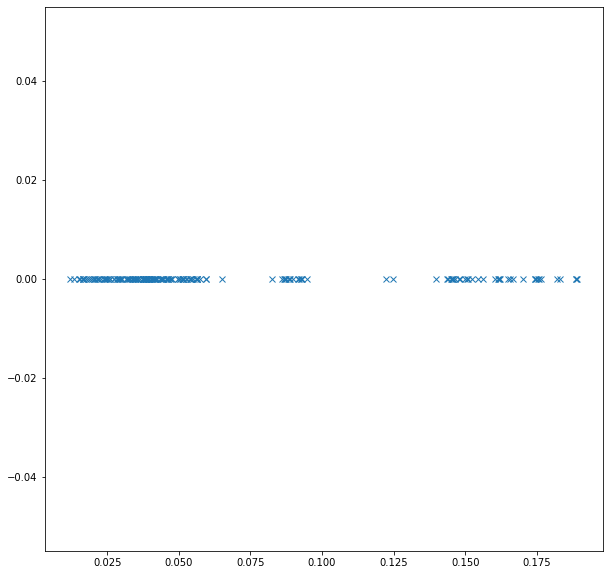

In [52]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(y_score, np.zeros_like(y_score) + val, 'x')
plt.show()

In [53]:
average_recon_error = np.mean(np.array(y_score))  
stdev_recon_error = np.std(np.array(y_score)) 
min_prob = np.min(y_score)
max_prob = np.max(y_score)
print("THIS IS FOR THE NON-ANOMALY IMAGES\n")
print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE NON-ANOMALY IMAGES

The average of the errors list is:  0.069289714
The standard deviation of the errors list is:  0.05204839
The min value of the errors list is:  0.012038647
The max value of the errors list is:  0.18914676


See that above, like in the case of the Autoencoder approach, the mean value of the non-anoamly images has two mean values; the values are distributed around two values, where ideally it was expected to be distributed around only one vlaue. 

If a threshold value were to be chosen, it would be the average of this reconstruction error list considering its standard deviation. That is:

mean = 0.069289714

std deviation = 0.052048404

Hence, every reconstruction error value that is outside the distribution given by mean and std_deviation should be classified as anomaly image, that is, a value:

rec_error = mean + std deviation + x. Where x>0, then rec_error will have more than 50% of being considered as anomaly

Or

rec_error = mean - std deviation - x. Where x>0, then rec_error will have more than 50% of being considered as anomaly

In [54]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [55]:
def computePredList(err_value_list):
    pred = 0
    pred_list = []
    prob_score_list =[]
    for i in range (len(err_value_list)):
        aux_score = err_value_list[i] - average_recon_error
        prob_score = ranges_mapper(abs(aux_score), 0, stdev_recon_error, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score = prob_score/100
        prob_score_list.append(prob_score)
        if prob_score > 0.5:
            pred = 1
        else:
            pred = 0
        pred_list.append(pred)
    return pred_list, prob_score_list

In [59]:
prediction, probability = computePredList([0.06928, 0.06928-0.052-0.01, 0.06928+0.052+0.01 ])
print(prediction)
print(probability)

[0, 1, 1]
[9.331795073637823e-05, 0.5956929258133248, 0.5955062899118522]


We will use above functions later.

Now, let's see the image that correspond to the highest error value

In [60]:
highest_error_index = np.where(y_score == 0.18914677)
print(highest_error_index)

(array([], dtype=int64),)


In [61]:
print(142/5)

28.4


The image with the highest reconstruction error corresponds to the 29th batch

In [62]:
for i, (x, label) in enumerate(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
    # print(i)
    if(i==28):
        x             = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)

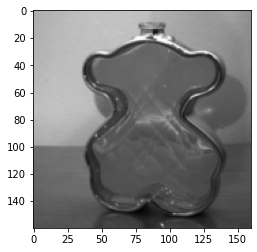

In [63]:
single_img = imgs_croped[2]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()
plt.imshow(single_img_numpy)

In [64]:
print(type(single_img))
print(single_img.shape)
single_img = single_img[None, :]
print(single_img.shape)

<class 'torch.Tensor'>
torch.Size([3, 160, 160])
torch.Size([1, 3, 160, 160])


In [65]:
bs            = 1

rec_image     = netG(netE(single_img))

d_input       = torch.cat((single_img, rec_image), dim=0)

f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)
x0            = single_img.reshape(single_img.size(0),-1)
x1            = rec_image.reshape([bs, OUTPUT_DIM]) 
rec_diff      = (x1 - x0)**2
rec_score     = rec_diff.mean(dim=1)
feat_diff     = ((f_x - f_gx)**2)
feat_score    = feat_diff.mean(dim=1)
outlier_score = rec_score + options_alpha * feat_score
print("The outlier score is: ",outlier_score)

The outlier score is:  tensor([0.1891], device='cuda:0', grad_fn=<AddBackward0>)


Now, the image with the lowest reconstruction error

In [66]:
lowest_error_index = np.where(y_score == 0.012038637)
print(lowest_error_index)

(array([], dtype=int64),)


In [67]:
39/5

7.8

The image with the lowest reconstruction error corresponds to the 8th batch

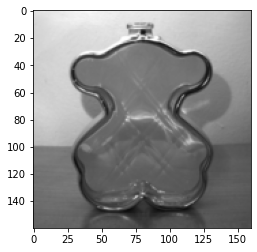

In [68]:
for i, (x, label) in enumerate(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
    # print(i)
    if(i==7):
        x             = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)

single_img = imgs_croped[4]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()
plt.imshow(single_img_numpy)

In [69]:
print(type(single_img))
print(single_img.shape)
single_img = single_img[None, :]
print(single_img.shape)
bs            = 1

rec_image     = netG(netE(single_img))

d_input       = torch.cat((single_img, rec_image), dim=0)

f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)
x0            = single_img.reshape(single_img.size(0),-1)
x1            = rec_image.reshape([bs, OUTPUT_DIM]) 
rec_diff      = (x1 - x0)**2
rec_score     = rec_diff.mean(dim=1)
feat_diff     = ((f_x - f_gx)**2)
feat_score    = feat_diff.mean(dim=1)
outlier_score = rec_score + options_alpha * feat_score
print("The outlier score is: ",outlier_score)

<class 'torch.Tensor'>
torch.Size([3, 160, 160])
torch.Size([1, 3, 160, 160])
The outlier score is:  tensor([0.0120], device='cuda:0', grad_fn=<AddBackward0>)


As it can be seen above, the problem is that the models are very susceptible to orientation changes of the image. See that the highest rec error is even higher than the rec error of real anomaly images.

## Checking the model performance with the test images

Actually working with the test set of images

In [70]:
netG = GoodGenerator().to(device)
netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
# netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netG.eval()
netD = GoodDiscriminator().to(device)
netD.load_state_dict(torch.load(D_Model))                                     #For home laptop, using GPU
# netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netD.eval()
netE = Encoder(DIM, NOISE_SIZE).to(device)
netE.load_state_dict(torch.load(E_Model))                                     #For home laptop, using GPU
# netE.load_state_dict(torch.load(E_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netE.eval()

_, test_set = one_class_dataloader(options_c, 0, BATCH_SIZE)
# crit = nn.MSELoss()


# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(test_set):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
           
        bs            = x.size(0)       
        x             = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x.cuda(), 60, 30, 160, 160)
        rec_image     = netG(netE(imgs_croped))                       # The result of the encoder model is fed to the generator model. The result is a batch of generated images
        d_input       = torch.cat((imgs_croped, rec_image), dim=0)    # Concatenation of the batch of images and their generated image. The result is of shape [120, 3, 64, 64] 

        f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)   

        x0            = imgs_croped.reshape(imgs_croped.size(0),-1)
        x1            = rec_image.reshape([bs, OUTPUT_DIM])  

        rec_diff      = (x1 - x0)**2
        rec_score     = rec_diff.mean(dim=1)

        feat_diff     = ((f_x - f_gx)**2)
        feat_score    = feat_diff.mean(dim=1)

        outlier_score = rec_score + options_alpha * feat_score

        y_true.append(label)
        y_score.append(outlier_score.cpu())
y_score = np.concatenate(y_score)
y_true = np.concatenate(y_true)
y_true[y_true != options_c] = -1
y_true[y_true == options_c] = 1



100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


In [71]:
print("y_true is: ", y_true)
print("y_true has shape: ", y_true.shape)

print("y_score is: ", y_score)
print("y_score has shape: ", y_score.shape)

y_true is:  [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1 -1 -1 -1 -1]
y_true has shape:  (30,)
y_score is:  [0.12001931 0.11753312 0.11436362 0.1149315  0.11374533 0.11273728
 0.1112707  0.11316951 0.11909964 0.11649659 0.12465624 0.12266212
 0.12421921 0.11861648 0.11478226 0.12039053 0.10394534 0.10429066
 0.11190863 0.12309296 0.12216909 0.1222201  0.12406124 0.12399639
 0.11870742 0.14276096 0.13873604 0.13795783 0.14114122 0.14729351]
y_score has shape:  (30,)


In [72]:
0.069289714+0.052048404

0.121338118

mean = 0.069289714

std deviation = 0.052048404

Now that we have the reconstruction error for all test set images, let's apply the thershold that was previously found based on the trianing set of images.

In [73]:
y_pred_threshold, y_prob_score = computePredList(y_score)
print(y_pred_threshold)
print(y_prob_score)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0.4873310800534197, 0.46344768718159146, 0.4329999936299501, 0.43845533303086337, 0.4270604588597482, 0.41737669462116567, 0.40328800505996687, 0.4215288220067046, 0.4784963217971729, 0.4534902255162299, 0.5318754794088851, 0.5127190930365835, 0.5276771870546557, 0.47385491731710955, 0.4370216423520429, 0.49089723441776634, 0.33291741917354967, 0.33623471214853695, 0.40941627939983827, 0.5168579077334768, 0.5079828535433188, 0.5084728463737919, 0.5261596836962437, 0.5255367071265041, 0.47472847304248544, 0.7057975256006224, 0.6671323244748842, 0.6596564624908197, 0.6902375692232969, 0.7493391788919734]


Finally, looking at the ground truth compared with the prediction list we have:


In [74]:
print("Ground truth is: ", y_true)
print("The prediction list is: ", y_pred_threshold)

Ground truth is:  [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1 -1 -1 -1 -1]
The prediction list is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In the ground truth list, "1" correspond to the non-anomaly and "-1" to the anomaly images. In the prediction list, "0" refers to the non-anomaly and "1" to the anomaly images. 

See that almost all the images are predicted to be anomaly images

Now, computing the AUC score with these lists

In [75]:
y_true_new = np.copy(y_true)
y_true_new[y_true_new==1]=0
y_true_new[y_true_new==-1]=1
print(y_true_new)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]


In [76]:
y_true_list = list(y_true_new)
print(y_true_list)
print(type(y_true_list))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
<class 'list'>


In [77]:
print('AUC = ', metrics.roc_auc_score(y_true_list, y_prob_score))            # It is passed as argument the negative of y_score, because y_true has values of 1 for the non-anomaly and -1 for the anomalies. If it were 0 for non-anomaly and 1 for the anomalies, then it would have been passed, positive y_score.


AUC =  1.0


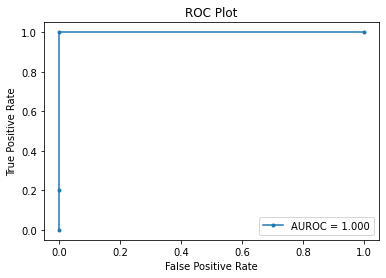

In [78]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_list, y_prob_score)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true_list, y_prob_score))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [79]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0. 0. 0. 1.]
The tpr is:  [0.  0.2 1.  1. ]
The thresholds are:  [1.74933918 0.74933918 0.65965646 0.33291742]


Now, the AUC score with the groudn truth not being changed to 0 and 1, is:

In [80]:
y_prob_score_array = np.array(y_prob_score)

print(y_prob_score_array)
print(type(y_prob_score_array))

[0.48733108 0.46344769 0.43299999 0.43845533 0.42706046 0.41737669
 0.40328801 0.42152882 0.47849632 0.45349023 0.53187548 0.51271909
 0.52767719 0.47385492 0.43702164 0.49089723 0.33291742 0.33623471
 0.40941628 0.51685791 0.50798285 0.50847285 0.52615968 0.52553671
 0.47472847 0.70579753 0.66713232 0.65965646 0.69023757 0.74933918]
<class 'numpy.ndarray'>


In [81]:
print('AUC = ', metrics.roc_auc_score(y_true, -y_prob_score_array))            # It is passed as argument the negative of y_score, because y_true has values of 1 for the non-anomaly and -1 for the anomalies. If it were 0 for non-anomaly and 1 for the anomalies, then it would have been passed, positive y_score.


AUC =  1.0


Above result is as expected

Now, let's get back to this result:

fpr, tpr, thresholds = metrics.roc_curve(y_true_list, y_prob_score)

It was shown that with a threshold of 0.33291768 the TPR is 1 and the FPR is 0. Let's checkt that

In [82]:
def computePredListV2(err_value_list):
    pred = 0
    pred_list = []
    prob_score_list =[]
    for i in range (len(err_value_list)):
        aux_score = err_value_list[i] - average_recon_error
        prob_score = ranges_mapper(abs(aux_score), 0, stdev_recon_error, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score = prob_score/100
        prob_score_list.append(prob_score)
        if prob_score > 0.33291768:
            pred = 1
        else:
            pred = 0
        pred_list.append(pred)
    return pred_list, prob_score_list

In [83]:
y_pred_threshold_V2, y_prob_score_V2 = computePredListV2(y_score)
print(y_score)
print(y_pred_threshold_V2)
print(y_prob_score_V2)


[0.12001931 0.11753312 0.11436362 0.1149315  0.11374533 0.11273728
 0.1112707  0.11316951 0.11909964 0.11649659 0.12465624 0.12266212
 0.12421921 0.11861648 0.11478226 0.12039053 0.10394534 0.10429066
 0.11190863 0.12309296 0.12216909 0.1222201  0.12406124 0.12399639
 0.11870742 0.14276096 0.13873604 0.13795783 0.14114122 0.14729351]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0.4873310800534197, 0.46344768718159146, 0.4329999936299501, 0.43845533303086337, 0.4270604588597482, 0.41737669462116567, 0.40328800505996687, 0.4215288220067046, 0.4784963217971729, 0.4534902255162299, 0.5318754794088851, 0.5127190930365835, 0.5276771870546557, 0.47385491731710955, 0.4370216423520429, 0.49089723441776634, 0.33291741917354967, 0.33623471214853695, 0.40941627939983827, 0.5168579077334768, 0.5079828535433188, 0.5084728463737919, 0.5261596836962437, 0.5255367071265041, 0.47472847304248544, 0.7057975256006224, 0.6671323244748842, 0.6596564624908197, 0.

The above result is supposed to have TPR of 1 and FPR 0.

In [84]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true_list,y_pred_threshold_V2)
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

[[ 0 25]
 [ 0  5]]
The FPR values are:  1.0
The TPR values are:  1.0


And no, the results do not coincide with the ones computed with the command:

fpr, tpr, thresholds = metrics.roc_curve(y_true_list, y_prob_score)

According to this command's results, shown below:

The fpr is:  [0. 0. 0. 1.]

The tpr is:  [0.  0.2 1.  1. ]

The thresholds are:  [1.74933884 0.74933884 0.65965613 0.33291768]


the 0.33291768 threshold should correspond to: TPR is 1 and the FPR is 0. But it does not, it corresponds to: TPR is 1 and the FPR is 1 

Let's try the 0.65965613 threshold

In [85]:
def computePredListV3(err_value_list):
    pred = 0
    pred_list = []
    prob_score_list =[]
    for i in range (len(err_value_list)):
        aux_score = err_value_list[i] - average_recon_error
        prob_score = ranges_mapper(abs(aux_score), 0, stdev_recon_error, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score = prob_score/100
        prob_score_list.append(prob_score)
        if prob_score > 0.65965613:
            pred = 1
        else:
            pred = 0
        pred_list.append(pred)
    return pred_list, prob_score_list

In [86]:
y_pred_threshold_V3, y_prob_score_V3 = computePredListV3(y_score)
print(y_pred_threshold_V3)
print(y_prob_score_V3)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0.4873310800534197, 0.46344768718159146, 0.4329999936299501, 0.43845533303086337, 0.4270604588597482, 0.41737669462116567, 0.40328800505996687, 0.4215288220067046, 0.4784963217971729, 0.4534902255162299, 0.5318754794088851, 0.5127190930365835, 0.5276771870546557, 0.47385491731710955, 0.4370216423520429, 0.49089723441776634, 0.33291741917354967, 0.33623471214853695, 0.40941627939983827, 0.5168579077334768, 0.5079828535433188, 0.5084728463737919, 0.5261596836962437, 0.5255367071265041, 0.47472847304248544, 0.7057975256006224, 0.6671323244748842, 0.6596564624908197, 0.6902375692232969, 0.7493391788919734]


In [87]:
conf_matrix = confusion_matrix(y_true_list,y_pred_threshold_V3)
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

[[25  0]
 [ 0  5]]
The FPR values are:  0.0
The TPR values are:  1.0


Above we see FPR = 0 and TPR = 1. This corresponds to the 0.65965613 threshold. This result is geniunily good. And good with the expected way of working, which is the prior computation of the trheshold over the trainign dataset. 